# Phase 1: Training the Leaky Adaptive Activation (LAA) Model

In this notebook we introduce the **Leaky Adaptive Activation (LAA)** model, a minimal yet expressive neuron model that retains the key features of membrane integration, leak, and spiking-like activation, while avoiding the discontinuities and high parameter count of classical LIF or the full Hodgkin–Huxley model where the number of parameters are typically >10.

---

## 1. LAA model definition

We model the membrane potential \(V(t)\) by the ODE:
$$
\boxed{
C_m \,\frac{dV}{dt}
=
-\,g_L\,(V - E_L)
\;+\;
I_{\rm ext}(t)
\;+\;
G_{\rm act}\,\sigma\bigl(V - V_{\rm thr};\,k\bigr)
}
$$

where the **sigmoidal activation** is
$$
\sigma(x; k) \;=\; \frac{1}{1 + e^{-\,k\,x}}.
$$

### Why LAA is simpler/better than LIF

- **Smooth dynamics**  
  Unlike LIF’s hard threshold + reset, the LAA ODE remains continuous and differentiable for all \(V\), which greatly simplifies gradient‐based inference.  
- **Fewer parameters**  
  We collapse all spiking currents into a single sigmoid block, reducing dozens of HH parameters down to just a handful.  
- **Flexible spike shape**  
  By tuning the sigmoid slope \(k\) and gain \(G_{\rm act}\), we can emulate a variety of spike amplitudes and widths—unlike the fixed‐amplitude, instantaneous reset in LIF.

---

## 2. Chosen parameters and priors

| Parameter       | Symbol         | Prior distribution                   | Rationale                                                   |
|-----------------|----------------|--------------------------------------|-------------------------------------------------------------|
| Membrane capacitance | $C_m$      | $\mathcal{U}(0.5, 2.0)\ \mu\mathrm{F/cm}^2$   | Typical cortical neuron $\,0.5\!-\!2$ scale               |
| Leak conductance     | $g_L$      | $\mathcal{U}(0.05, 0.20)\ \mathrm{mS/cm}^2$  | Sets $\tau_m=C_m/g_L\approx 5\!-\!40$ ms                   |
| Resting potential    | $E_L$      | $\mathcal{U}(-80,\,-60)\ \mathrm{mV}$       | Physiological resting range                                |
| Activation threshold | $V_{\rm thr}$ | $\mathcal{U}(-50,\,-40)\ \mathrm{mV}$      | Spike “trigger” around $-50$ mV                          |
| Activation slope     | $k$        | $\mathcal{U}(0.1,\,1.0)\ \mathrm{mV}^{-1}$   | Controls spike sharpness: low $k$=soft, high $k$=steep |
| Activation gain      | $G_{\rm act}$ | (fixed) $=g_L$                          | Normalizes activation current to leak scale                |

> *We fix $G_{\rm act}=g_L$ for identifiability; if needed, one can promote it to a free parameter.*

---

## 3. Prior predictive equation for sampling

To generate our training data $(\theta_i,\,V_i(t))$, we first draw parameters  
$$
\theta = \bigl(C_m,\,g_L,\,E_L,\,V_{\rm thr},\,k\bigr)
\;\sim\;
p(\theta)
=
\mathcal{U}(0.5,2.0)\times\mathcal{U}(0.05,0.20)\times\mathcal{U}(-80,-60)\times\mathcal{U}(-50,-40)\times\mathcal{U}(0.1,1.0)
$$
then solve
$$
C_m \,\frac{dV}{dt}
=
-\,g_L\,(V - E_L)
\;+\;
I_{\rm ext}(t)
\;+\;
g_L\,\sigma(V - V_{\rm thr};k)
\quad\text{on }t\in[0,T].
$$

These $$(\theta_i,\,V_i(t))$$ pairs form the **prior predictive** dataset for training our neural density estimator in Phase 2.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import bayesflow as bf

INFO:bayesflow:Using backend 'jax'


### Defining the prior

In [2]:
import numpy as np
from bayesflow.simulators import Simulator, make_simulator, LambdaSimulator
import jax.numpy as jnp
import pandas as pd

In [3]:
def draw_prior():
    """
    Draws one sample from the prior distributions of the LAA model parameters.
    Returns a dictionary with named entries.
    """

    prior_draws = np.random.uniform(
        low=(0.5, 0.05, -80, -50, 0.1),     # (C_m, g_L, E_L, V_thr, k)
        high=(2.0, 0.2, -60, -40, 1.0)
    )

    prior_dict = {
        "C_m": prior_draws[0],
        "g_L": prior_draws[1],
        "E_L": prior_draws[2],
        "V_thr": prior_draws[3],
        "k": prior_draws[4]
    }

    return prior_dict

In [ ]:
# def draw_prior_batch(batch_size):
#     return [draw_prior() for _ in range(batch_size)]

# test = draw_prior_batch(10)
# display(test)

In [ ]:
# Sampling batches for simulation

def draw_prior_batch_dict(batch_size):
    draws = np.random.uniform(
        low=(0.5, 0.05, -80, -50, 0.1),
        high=(2.0, 0.2, -60, -40, 1.0),
        size=(batch_size, 5)
    )

    return {
        "C_m":   draws[:, 0],
        "g_L":   draws[:, 1],
        "E_L":   draws[:, 2],
        "V_thr": draws[:, 3],
        "k":     draws[:, 4]
    }

test = draw_prior_batch_dict(10)
display(test)

### Defining alternative priors

Evaluate different prior families (Uniform, Gamma, Truncated Gaussian, Beta) for each of our five LAA parameters and perform prior‐predictive checks (voltage traces) under each prior choice. Suggested is to choose the one that yields the most realistic behavior.

In [3]:
import numpy as np
from scipy.stats import truncnorm, beta, gamma

def draw_prior_uniform():
    u = np.random.uniform
    return {
        "C_m":   u(0.5, 2.0),
        "g_L":   u(0.05, 0.2),
        "E_L":   u(-80, -60),
        "V_thr": u(-50, -40),
        "k":     u(0.1, 1.0)
    }

def draw_prior_gamma():
    # Shape+scale roughly match uniform mean
    return {
        "C_m":   gamma(a=2, scale=0.5).rvs(),
        "g_L":   gamma(a=2, scale=0.05).rvs(),
        "E_L":   truncnorm(( -80+70)/10,(-60+70)/10, loc=-70, scale=10).rvs(),   # approx
        "V_thr": truncnorm((-50+45)/5,(-40+45)/5, loc=-45, scale=5).rvs(),
        "k":     gamma(a=2, scale=0.5).rvs()
    }

def draw_prior_truncnorm():
    def trnorm(mean, sd, low, high):
        a, b = (low-mean)/sd, (high-mean)/sd
        return truncnorm(a, b, loc=mean, scale=sd).rvs()
    return {
        "C_m":   trnorm(1.0, 0.3, 0.5, 2.0),
        "g_L":   trnorm(0.12,0.05,0.05,0.2),
        "E_L":   trnorm(-70, 5, -80, -60),
        "V_thr": trnorm(-45,5, -50, -40),
        "k":     trnorm(0.5,0.2, 0.1, 1.0)
    }

def draw_prior_beta():
    def betadraw(a, b, low, high):
        return beta(a, b).rvs() * (high-low) + low
    return {
        "C_m":   betadraw(2,2, 0.5, 2.0),
        "g_L":   betadraw(2,5, 0.05,0.2),
        "E_L":   betadraw(5,5, -80,-60),
        "V_thr": betadraw(2,2, -50,-40),
        "k":     betadraw(2,1, 0.1,1.0)
    }


Prior predictive checks

### Defining the simulator

We simulate by integrating the defined ODE equation for the LAA model, forward in time for each theta(i), by tuning the slopes k and gain Gact - we aim to shape the "spike" amplitude and width continously.

In [7]:
import numpy as np
from scipy.integrate import solve_ivp

def sigmoid(x, k):
    return 1 / (1 + np.exp(-k * x))

def laa_rhs(t, V, params, I_ext_func):
    """
    Right-hand side of LAA model ODE.
    """
    C_m = params['C_m']
    g_L = params['g_L']
    E_L = params['E_L']
    V_thr = params['V_thr']
    k = params['k']
    G_act = g_L  # fixed for simplicity

    I_ext = I_ext_func(t)

    dVdt = (-g_L * (V - E_L) + I_ext + G_act * sigmoid(V - V_thr, k)) / C_m
    return dVdt

def simulate_voltage_trace(params, T=100.0, dt=0.1):
    """
    Simulates V(t) over time using the LAA model ODE.
    
    Parameters:
    - params: dict with keys C_m, g_L, E_L, V_thr, k
    - T: total simulation time in ms
    - dt: time step in ms
    """
    t_span = (0, T)
    t_eval = np.arange(0, T, dt)

    # Constant external current for now
    def I_ext(t):
        return 1.5  # µA/cm² (tweak as needed)

    # Initial condition
    V0 = [params['E_L']]

    sol = solve_ivp(
        fun=lambda t, V: laa_rhs(t, V, params, I_ext),
        t_span=t_span,
        y0=V0,
        t_eval=t_eval,
        method='RK45'
    )

    return sol.t, sol.y[0]

Prior Predictive Check

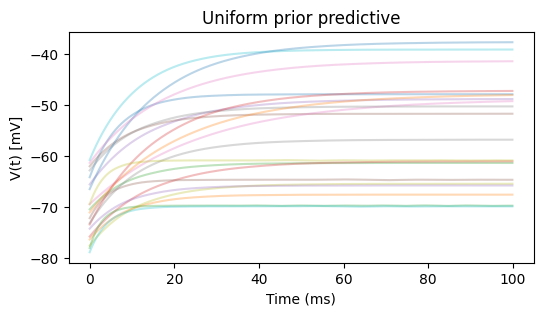

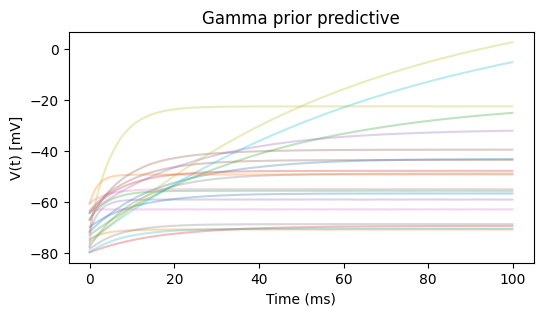

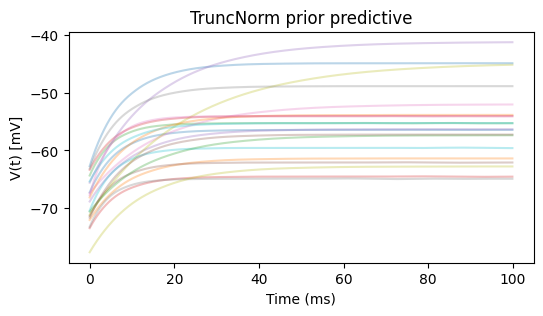

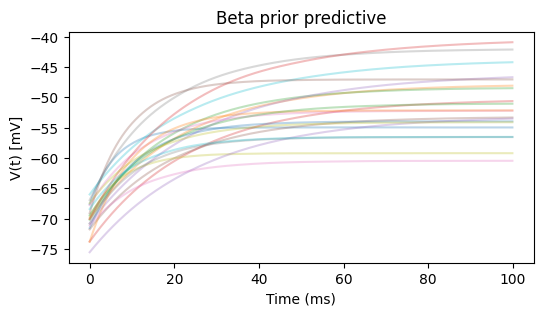

In [9]:
# 1. Prior‐predictive plot with your constant‐current sim
import matplotlib.pyplot as plt

for name, sampler in [
    ("Uniform", draw_prior_uniform),
    ("Gamma",   draw_prior_gamma),
    ("TruncNorm", draw_prior_truncnorm),
    ("Beta",    draw_prior_beta),
]:
    plt.figure(figsize=(6,3))
    for _ in range(20):
        p = sampler()
        t, V = simulate_voltage_trace(p)    # use your simulate_voltage_trace
        plt.plot(t, V, alpha=0.3)
    plt.title(f"{name} prior predictive")
    plt.xlabel("Time (ms)")
    plt.ylabel("V(t) [mV]")
    plt.show()


In [10]:
def simulate_voltage_trace_spike(params, T=100.0, dt=0.1):
    t_eval = np.arange(0, T, dt)
    def I_ext(t):
        return 0.0 if t<20 else 20.0

    sol = solve_ivp(
        fun=lambda t, V: laa_rhs(t, V, params, I_ext),
        t_span=(0, T),
        y0=[params["E_L"]],
        t_eval=t_eval,
        method="RK45"
    )
    return sol.t, sol.y[0]


/var/folders/00/g6wzklhx6nj9649_f1shk6lc0000gp/T/ipykernel_42493/283282390.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * x))


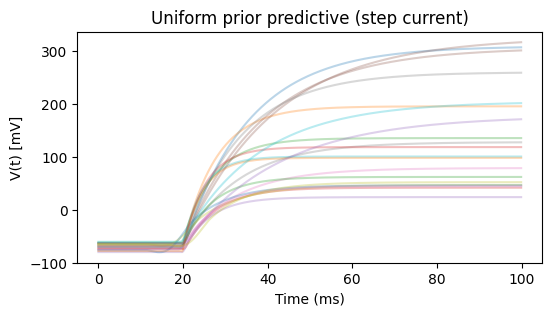

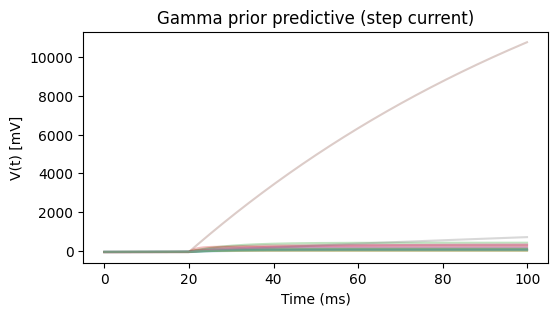

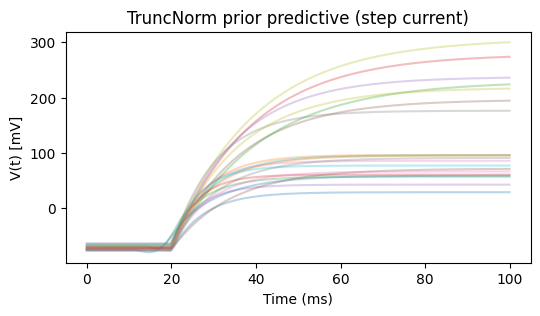

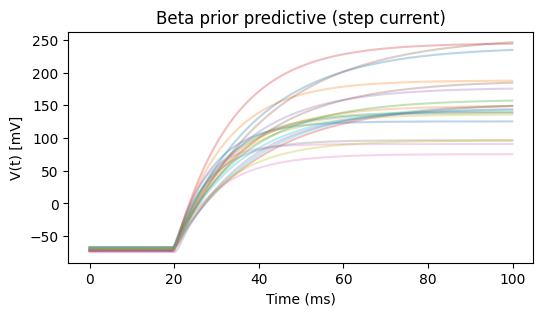

In [12]:
import matplotlib.pyplot as plt

# List the actual (name, function) pairs
prior_variants = [
    ("Uniform",     draw_prior_uniform),
    ("Gamma",       draw_prior_gamma),
    ("TruncNorm",   draw_prior_truncnorm),
    ("Beta",        draw_prior_beta),
]

for name, sampler in prior_variants:
    plt.figure(figsize=(6,3))
    for _ in range(20):
        p = sampler()
        t, V = simulate_voltage_trace_spike(p)
        plt.plot(t, V, alpha=0.3)
    plt.title(f"{name} prior predictive (step current)")
    plt.xlabel("Time (ms)")
    plt.ylabel("V(t) [mV]")
    plt.show()


In [14]:
import numpy as np

def likelihood(C_m, g_L, E_L, V_thr, k):
    """
    BayesFlow will pass in either:
      - arrays of shape (n,1), or
      - scalars/0-D arrays when n=1.
    We convert all inputs to a 1-D numpy array of length batch_size.
    """
    # Ensure 1-D arrays
    C_m_arr   = np.atleast_1d(C_m).reshape(-1)
    g_L_arr   = np.atleast_1d(g_L).reshape(-1)
    E_L_arr   = np.atleast_1d(E_L).reshape(-1)
    V_thr_arr = np.atleast_1d(V_thr).reshape(-1)
    k_arr     = np.atleast_1d(k).reshape(-1)

    batch_size = C_m_arr.size
    traces = []

    for i in range(batch_size):
        params = {
            "C_m":   float(C_m_arr[i]),
            "g_L":   float(g_L_arr[i]),
            "E_L":   float(E_L_arr[i]),
            "V_thr": float(V_thr_arr[i]),
            "k":     float(k_arr[i]),
        }
        _, V = simulate_voltage_trace(params)
        traces.append(V)

    # Stack into shape (batch_size, time_steps)
    data = np.stack(traces, axis=0)
    return {"data": data}


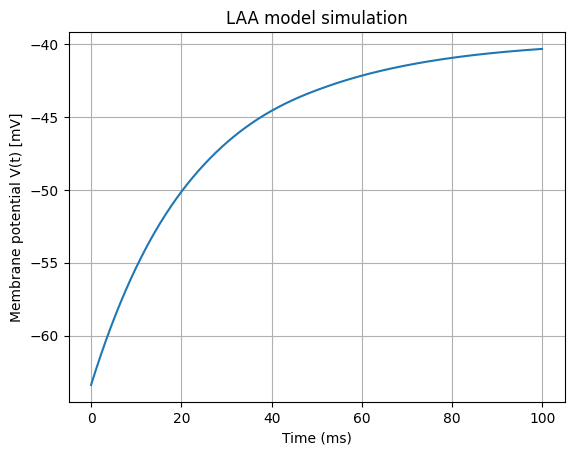

In [15]:
# single sample run to test the simulation

params = draw_prior()
t, V = simulate_voltage_trace(params)
params['V_thr'] = -55  # Lower than the current V range
params['k'] = 3.0  # sigmoid becomes more step-like

import matplotlib.pyplot as plt
plt.plot(t, V)
plt.xlabel("Time (ms)")
plt.ylabel("Membrane potential V(t) [mV]")
plt.title("LAA model simulation")
plt.grid()
plt.show()


### Connecting Prior and Simulator

In [16]:
from bayesflow.simulators import make_simulator

# Create simulator object
simulator = make_simulator([draw_prior, likelihood])


In [17]:
# Generate 5 samples
dataset = simulator.sample(5)

for name, arr in dataset.items():
    print(f"{name:6s} → {arr.shape}")


C_m    → (5, 1)
g_L    → (5, 1)
E_L    → (5, 1)
V_thr  → (5, 1)
k      → (5, 1)
data   → (5, 1, 1000)


/var/folders/00/g6wzklhx6nj9649_f1shk6lc0000gp/T/ipykernel_35401/283282390.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * x))


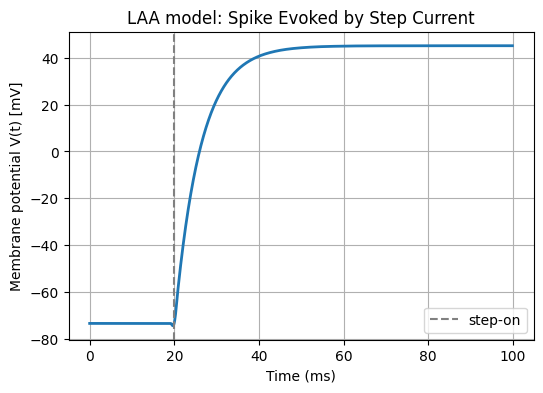

In [18]:
# Single-sample run with a stronger input and sharper activation
params = draw_prior()
# Override to guarantee spiking
params['V_thr'] = -55    # lower threshold
params['k']      = 5.0   # very steep sigmoid

# Redefine simulate_voltage_trace with a step current
def simulate_voltage_trace_spike(params, T=100.0, dt=0.1):
    t_eval = np.arange(0, T, dt)
    def I_ext(t):
        # step current: zero until t=20 ms, then strong depolarizing current
        return 0.0 if t < 20 else 20.0

    sol = solve_ivp(
        fun=lambda t, V: laa_rhs(t, V, params, I_ext),
        t_span=(0, T),
        y0=[params["E_L"]],
        t_eval=t_eval,
        method="RK45"
    )
    return sol.t, sol.y[0]

# Run it
t, V = simulate_voltage_trace_spike(params)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(t, V, lw=2)
plt.axvline(20, color='gray', linestyle='--', label='step-on')
plt.xlabel("Time (ms)")
plt.ylabel("Membrane potential V(t) [mV]")
plt.title("LAA model: Spike Evoked by Step Current")
plt.legend()
plt.grid(True)
plt.show()
